In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import f
from scipy.stats import chi2
from scipy.optimize import curve_fit


try:
    import seaborn as sns
    sns.set_style("ticks") 
    #sns.set_style({"axes.axisbelow": False})
    sns.set_style({"xtick.direction": "in" ,"ytick.direction": "in"})
except:
    print("sns problem")

import pandas as pd
try:
    from like_3FGL import *
except:
    print("Can't import like_3FGL")


from likeSED import *



sns problem
Initializing Fermi and HEASOFT software.
Importing Python modules.

Plotter is MatPlotlib
This is make3FGLxml version 01r0.
The default diffuse model files and names are for pass 8 and assume you have v10r00p05 of the Fermi Science Tools or higher.
This is likeSED version 12.1, modified to handle Pass 7 selections.


In [2]:
import cPickle as pickle

def dump_pickle(self, filename):
    output = open(filename, 'wb')
    pickle.dump(self, output, protocol=pickle.HIGHEST_PROTOCOL)
    output.close()

### End of class PyHiLo

def load_pickle(filename):
    f_in = file(filename, 'rb')
    hilo = pickle.load(f_in)
    f_in.close()
    return hilo

gev2erg = 0.00160217
gev2hz = 2.4180e23



In [3]:
def getSED(sed,plot=True, plot_sed=False, save_spec=None, save_sed=None, eminGeV=0.1, emaxGeV=300):
    minEs=sed.likeIn.bins[0]
    maxEs=sed.likeIn.bins[1]
    ecent=sed.centers
    fluxPts=sed.data[0]
    fluxErrs=sed.data[1]
    tsbands=sed.data[2]
    gammas=sed.data[3]

    XTitle='Energy (GeV)'
    YTitle=[r'dN/dE (cm$^{-2}$ s$^{-1}$ GeV$^{-1}$ )',r'E$^{2}$dN/dE (erg cm$^{-2}$ s$^{-1}$ )',r'$\nuF_{\nu}$ (erg cm$^{-2}$ s$^{-1}$ )']
    #let's make the graphs for the model, both the counts spectrum and the E^2dN/dE spectrum
    modBins=log_array(51,sed.FitBounds[0]/1000.,sed.FitBounds[1]/1000.)
    modelEcent=[0.5*(e1+e2) for e1,e2 in zip(modBins[:-1],modBins[1:])]
    modEs=num.array(modelEcent)
    modFs=num.array(sed.Fit)
    modesq=[y*x**2*0.001602 for x,y in zip(modelEcent,sed.Fit)]
    modEsq=num.array(modesq)
    #plt.plot(modEs,modFs)
    #plt.plot(modEs,modEsq)
    if(len(sed.BT)>1):
        up=[]
        down=[]
        for x,y,z in zip(modesq,sed.BT,modelEcent):
            up+=[x+y*z**2*0.001602]
            down+=[x-y*z**2*0.001602]
        Up=num.array(up)
        Down=num.array(down)
    plotMax=max(maxEs[-1],sed.FitBounds[1])
    plotMin=min(minEs[0],sed.FitBounds[0])
    if len(sed.data[3])==0:
        GeVfluxPts=[float(x*1000.) for x in fluxPts if x!=0]#need to check for points with zero flux
        GeVfluxErrs=[float(x*1000.) for x,X in zip(fluxErrs,fluxPts) if X!=0]#means energy band fit failed
    else:
        newfluxPts=[]
        newfluxErrs=[]
        for m,M,f,e,g,c in zip(minEs,maxEs,fluxPts,fluxErrs,sed.data[3],ecent):
            if g!=1 and f!=0:
                newfluxPts+=[f*(-g+1)*(c*1000.)**(-g)/(M**(-g+1)-m**(-g+1))] #works out to be prefactor assuming Scale parameter (E0) of c (center en
                newfluxErrs+=[e*(-g+1)*(c*1000.)**(-g)/(M**(-g+1)-m**(-g+1))]#similar for the errors
            else:
                if f!=0:
                    newfluxPts+=[f/(c*log(M/m))]
                    newfluxErrs+=[e/(c*log(M/m))]
        GeVfluxPts=[float(x*1000.) for x in newfluxPts]
        GeVfluxErrs=[float(x*1000.) for x in newfluxErrs]
    Fluxes=num.array(GeVfluxPts)
    FErrors=num.array(GeVfluxErrs)
    dataLow=min(GeVfluxPts)
    dataHigh=max(GeVfluxPts)

    cntArrows=[] #create lists to be filled with TArrows for upper limits points for dN/dE spectrum, TArrows not saved, only used if plo
    flxArrows=[] #same as above but for E^2dN/dE spectrum
    newecent=[]
    for e,f in zip(ecent,fluxPts):
        if f!=0:
            newecent+=[e]
    energies=num.array(newecent)
    esqf=[]
    esqfErr=[]
    GeVBands=[float(x/1000.) for x in minEs]
    GeVBands+=[float(maxEs[-1]/1000.)]
    Bands=num.array(GeVBands) #make an array that TH1F will recognize for binning purposes
    if(len(sed.data[3])==0):
        for x,y,z in zip(energies,GeVfluxPts,GeVfluxErrs):
            if y!=0:
                esqf+=[y*x**2*0.001602]
                esqfErr+=[z*x**2*0.001602]
    else:
        for x,y,z,g,e,E in zip(ecent,fluxPts,fluxErrs,gammas,minEs,maxEs):
            if g!=1 and y!=0:
                esqf+=[y*x**(2-g)*(g-1)/((e/1000.)**(1-g)-(E/1000.)**(1-g))*0.001602]
                esqfErr+=[z*x**(2-g)*(g-1)/((e/1000.)**(1-g)-(E/1000.)**(1-g))*0.001602]
            else:
                if y!=0:
                    esqf+=[y/(x*log(E/e))*(E*log(E)-e*log(e)-E+e)]
                    esqfErr+=[z/(x*log(E/e))*(E*log(E)-e*log(e)-E+e)]
    EsqFluxes=num.array(esqf)
    EsqFErrors=num.array(esqfErr)
    eminus=[]
    eplus=[]
    newminEs=[]
    newmaxEs=[]
    for e,E,f in zip(minEs,maxEs,fluxPts):
        if f!=0:
            newminEs+=[e]
            newmaxEs+=[E]
    for x,y,z in zip(energies,newminEs,newmaxEs):
        eminus+=[x-(y/1000.)]
        eplus+=[(z/1000.)-x]
    Eminus=num.array(eminus)
    Eplus=num.array(eplus)
    
    
    like = sed.likeIn.ubAn
    name = sed.likeIn.source
    #N0_scale = like.model[name].funcs['Spectrum'].getParam('Scale').value()
    N0_scale=1.e-10
    N0 = like.model[name].funcs['Spectrum'].getParam('Prefactor').value()*N0_scale
    N0_err = like.model[name].funcs['Spectrum'].getParam('Prefactor').error()*N0_scale

    gamma = like.model[name].funcs['Spectrum'].getParam('Index').value()
    gamma_err = like.model[name].funcs['Spectrum'].getParam('Index').error()
    E0 = like.model[name].funcs['Spectrum'].getParam('Scale').value()
    freeParValues = []
    for sourcename in like.sourceNames():
        for element in like.freePars(sourcename):
            freeParValues.append(element.getValue())
        g_index = freeParValues.index(like.freePars(name)[1].getValue())
        cov_gg = like.covariance[g_index][g_index]
    fPL = lambda E,N0,E0,gamma: N0*(E/E0)**(-1*gamma)
    ferrPL = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)


    #EGeV = np.logspace(np.log10(eminGeV),np.log10(emaxGeV),100)
    EGeV = np.logspace(np.log10(ecent[0]-Eminus[0]),np.log10(ecent[-1]+Eplus[-1]),100)
    FGeV = fPL(EGeV,N0*1.e3,E0/1000.,gamma)
    FGeVerr = ferrPL(EGeV,FGeV,N0*1.e3,N0_err*1.e3,E0/1000.,cov_gg)


    if plot:
        fig = plt.figure(figsize=(5, 5))
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

        ax = fig.add_subplot(111)
        ax.set_xlabel('E (GeV)')
        ax.set_ylabel(r'dN/dE (cm$^{-2}$ s$^{-1}$ GeV$^{-1}$ )')

        ax.errorbar(ecent, GeVfluxPts, xerr=[Eminus, Eplus], yerr=GeVfluxErrs, color='r',ecolor='r', capthick=0, fmt='.') #, label="GeVfluxPts")
        ax.plot(EGeV,FGeV, 'r--')
        ax.fill_between(EGeV,(FGeV-FGeVerr), (FGeV+FGeVerr), alpha=0.3,color='r')
        
        ul_slice = np.where(np.array(GeVfluxErrs)==0)
        ax.errorbar(np.array(ecent)[ul_slice], np.array(GeVfluxPts)[ul_slice], 
                    yerr=6.e-1*np.array(GeVfluxPts)[ul_slice], uplims=True, fmt='.', 
                    color='r',ecolor='r')
            
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlim(100,3000)
        ax.legend(loc='best')
        plt.tight_layout()
        if save_spec:
            plt.savefig(save_spec, dpi=300)
        plt.show()
    if plot_sed:
        gev2erg = 0.00160217
        gev2hz = 2.4180e23

        fig = plt.figure(figsize=(5, 5))
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

        ax = fig.add_subplot(111)
        ax.set_xlabel('E (GeV)')

        ax.set_ylabel(r'E$^{2}$dN/dE (erg cm$^{-2}$ s$^{-1}$ )')

        ax.errorbar(ecent, EsqFluxes, xerr=[Eminus, Eplus], yerr=EsqFErrors, color='b', ecolor='b', capthick=0, fmt='.', label="LAT")

        ax.plot(EGeV,(EGeV)**2*FGeV*gev2erg, 'b--')
        ax.fill_between(EGeV,(EGeV)**2*(FGeV-FGeVerr)*gev2erg, (EGeV)**2*(FGeV+FGeVerr)*gev2erg,alpha=0.3,color='b')

        ul_slice = np.where(np.array(EsqFErrors)==0)
        ax.errorbar(np.array(ecent)[ul_slice], np.array(EsqFluxes)[ul_slice], 
                    6.e-1*np.array(EsqFluxes)[ul_slice], uplims=True, fmt='.', 
                    color='b',ecolor='b')


        #for ul_index in ul_slice:
        #    ax.arrow(np.array(ecent)[ul_index], np.array(EsqFluxes)[ul_index], 
        #             0, -1.e-3*np.array(EsqFluxes)[ul_index],
        #             ec='b', fc='b', lw=1)


        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlim(100,3000)
        ax.legend(loc='best')
        plt.tight_layout()
        if save_sed:
            plt.savefig(save_sed, dpi=300)
        plt.show()
       
    return ecent, GeVfluxPts, GeVfluxErrs, Eminus, Eplus, EsqFluxes, EsqFErrors, EGeV, FGeV, FGeVerr



* Equatorial coordinates (degrees)	(238.929,11.1901)
* Time range (MET)	(239587201,509328005)
* Time range (Gregorian)	(2008-08-05 00:00:00,2017-02-21 00:00:00)
* Energy range (MeV)	(100,300000)
* Search radius (degrees)	10


In [12]:
ev_file_tag='10degPG1553all'
day_sec = 86400.


pg_all = analyze3FGL(name='3FGL J1555.7+1111', id_string='PG1553', ra=238.929, dec=11.1901,
                 work_dir='.', d_dir='.', e_dir='events/', emin=100, emax=300000,
                 ext_dir='/Users/qifeng/Data/Blazars/BLLac/Fermi/Extended_archive_v15/Templates/',
                 evlistname='@pg1553_all.list', scfilename='L1702211531290762B87135_SC00.fits',
                 do_diffuse=True, ev_file_tag=ev_file_tag, fname_DT='PG1553_results_all.txt',
                 model='PG1553_3FGL_model_100MeV-300GeV_all.xml', modeloutbase='PG1553_3FGL_model_100MeV-300GeV_all_out', 
                 rad=10, srcrad=20, TS_lower=5.0)

pg_all.roicut = 'yes'

Opening file stream for writing results.



In [ ]:
pg_all.run(t_start=239587201, t_stop=509328005,
              diagnostic_file="Diagnostic_plot" + str("{0}".format(ev_file_tag)) + ".png")





* Running gtselect *

time -p /Users/qifeng/soft/ScienceTools-v10r0p5-fssc-20160831/x86_64-apple-darwin16.1.0/bin/gtselect infile=@pg1553_all.list outfile=./events/PG1553_10degPG1553allfiltered_events.fits ra=238.929 dec=11.1901 rad=10.0 tmin=239587201.0 tmax=509328005.0 emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass=128 evclsmin=0 evclsmax=10 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 40.50
user 38.11
sys 2.01
* Running gtmktime *

time -p /Users/qifeng/soft/ScienceTools-v10r0p5-fssc-20160831/x86_64-apple-darwin16.1.0/bin/gtmktime scfile=./L1702211531290762B87135_SC00.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)" roicut=yes evfile=./events//PG1553_10degPG1553allfiltered_events.fits evtable="EVENTS" outfile="./events//PG1553_10degPG1553allfiltered_gti_events.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui

In [4]:
#pg_all.make_TSmap(outname='PG1553_3FGL_model_all_residual.fits', xmlname='PG1553_3FGL_model_100MeV-300GeV_all_out_2.xml')



* Running Tsmap *

time -p /Users/qifeng/soft/ScienceTools-v10r0p5-fssc-20160831/x86_64-apple-darwin16.1.0/bin/gttsmap irfs="CALDB" evtype="INDEF" expcube=./events//expCube_10deg2016flare3daysBLLac.fits srcmdl=BLLac_3FGL_modelPL_LC_100MeV-300GeVsimple_3dayspec_2.xml statistic="UNBINNED" optimizer="NEWMINUIT" ftol=0.001 toltype="ABS" evfile=./events//BLLac_10deg2016flare3daysfiltered_gti_events.fits evtable="EVENTS" scfile=./L1701271500537C62B87191_SC00.fits sctable="SC_DATA" expmap=./events//expMap_10deg2016flare3daysBLLac.fits cmap=none bexpmap=none psfcorr=yes outfile=BLLac_3FGL_modelPL_3day_residual.fits nxpix=25 nypix=25 binsz=0.5 coordsys="CEL" xref=330.68 yref=42.2778 proj="STG" chatter=2 debug=no clobber=yes gui=no mode="ql"
.Minuit abnormal termination.  No convergence?
.Minuit abnormal termination.  No convergence?
Minuit abnormal termination.  No convergence?
..Minuit abnormal termination.  No convergence?
Minuit abnormal termination.  No convergence?
..Minuit abnormal termin

In [6]:
#pg_all.make_TSmap(outname='PG1553_3FGL_model_all_source.fits', xmlname='PG1553_3FGL_model_100MeV-300GeV_all_out_2_noSource.xml') 

* Running Tsmap *

time -p /Users/qifeng/soft/ScienceTools-v10r0p5-fssc-20160831/x86_64-apple-darwin16.1.0/bin/gttsmap irfs="CALDB" evtype="INDEF" expcube=./events//expCube_10deg2016flare3daysBLLac.fits srcmdl=BLLac_3FGL_modelPL_LC_100MeV-300GeVsimple_3dayspec_2_noSource.xml statistic="UNBINNED" optimizer="NEWMINUIT" ftol=0.001 toltype="ABS" evfile=./events//BLLac_10deg2016flare3daysfiltered_gti_events.fits evtable="EVENTS" scfile=./L1701271500537C62B87191_SC00.fits sctable="SC_DATA" expmap=./events//expMap_10deg2016flare3daysBLLac.fits cmap=none bexpmap=none psfcorr=yes outfile=BLLac_3FGL_modelPL_3day_source.fits nxpix=25 nypix=25 binsz=0.5 coordsys="CEL" xref=330.68 yref=42.2778 proj="STG" chatter=2 debug=no clobber=yes gui=no mode="ql"
.Minuit abnormal termination.  No convergence?
Minuit abnormal termination.  No convergence?
.Minuit abnormal termination.  No convergence?
....Minuit abnormal termination.  No convergence?
.Minuit abnormal termination.  No convergence?
.........Minui

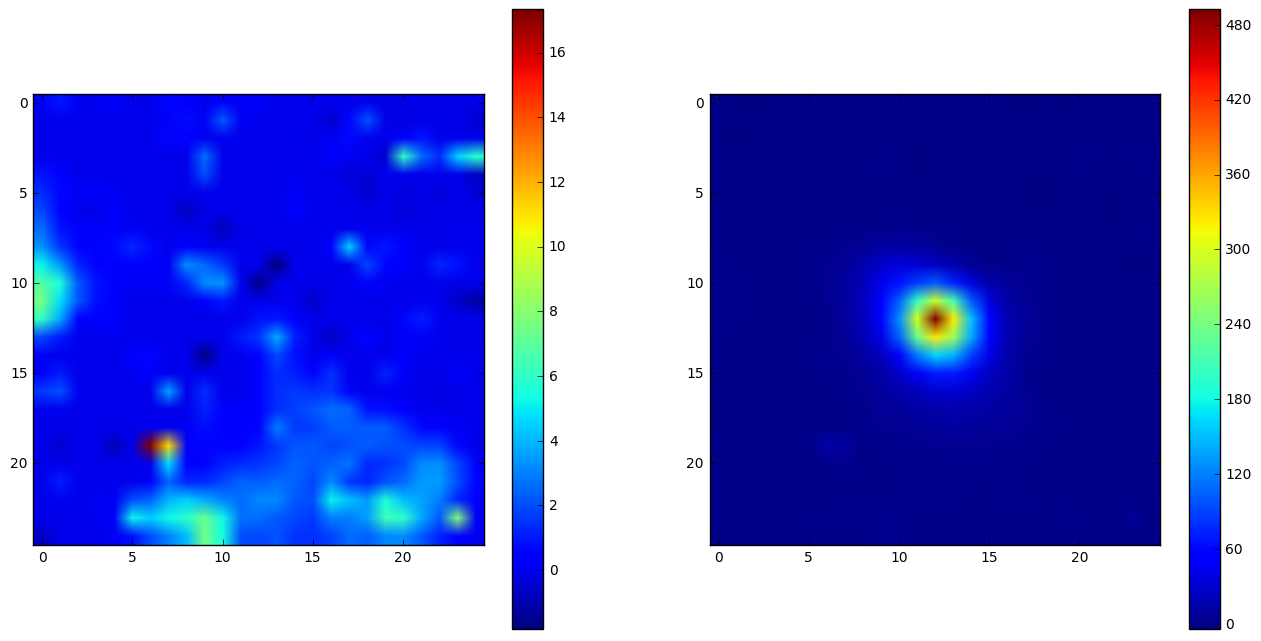

In [7]:
import pyfits
residHDU = pyfits.open('PG1553_3FGL_model_all_residual.fits')
sourceHDU = pyfits.open('PG1553_3FGL_model_all_source.fits')
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(residHDU[0].data)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sourceHDU[0].data)
plt.colorbar()
plt.savefig("PG1553_all_TSmaps.png", dpi=300)
plt.show()


In [8]:
print("Peak significance in residual map is {} and in source map is {} ".format(np.max(residHDU[0].data), np.max(sourceHDU[0].data)))

Peak significance in residual map is 17.3403320312 and in source map is 492.47644043 


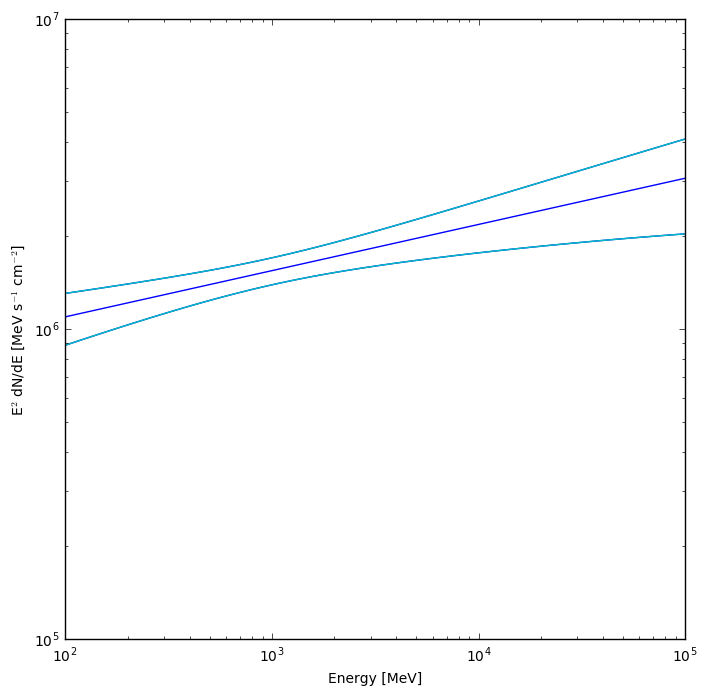

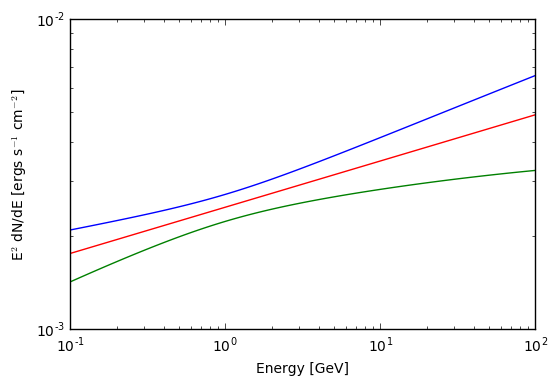

In [24]:
like = pg_all.like
obs = pg_all.obs
name = pg_all.name
#N0_scale = like.model[name].funcs['Spectrum'].getParam('Scale').value()
N0_scale=1
N0 = like.model[name].funcs['Spectrum'].getParam('Prefactor').value()*N0_scale
N0_err = like.model[name].funcs['Spectrum'].getParam('Prefactor').error()*N0_scale

gamma = like.model[name].funcs['Spectrum'].getParam('Index').value()
gamma_err = like.model[name].funcs['Spectrum'].getParam('Index').error()
E0 = like.model[name].funcs['Spectrum'].getParam('Scale').value()
freeParValues = []
for sourcename in like.sourceNames():
    for element in like.freePars(sourcename):
        freeParValues.append(element.getValue())
    g_index = freeParValues.index(like.freePars(name)[1].getValue())
    cov_gg = like.covariance[g_index][g_index]
f = lambda E,N0,E0,gamma: N0*(E/E0)**(-1*gamma)
ferr = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)
ferr2 = lambda E,F,N0,N0err,E0,gamma,dgamma: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2) * dgamma**2)

E = np.logspace(2,5,100)
F = f(E,N0,E0,gamma)
Ferr = ferr(E,F,N0,N0_err,E0,cov_gg)
Ferr2 = ferr2(E,F,N0,N0_err,E0,gamma,gamma_err)

plt.figure(figsize=(8,8))
plt.xlabel('Energy [MeV]')
plt.ylabel(r'E$^2$ dN/dE [MeV s$^{-1}$ cm$^{-2}$]')
plt.loglog(E,E**2*(F+Ferr), 'b-')
plt.loglog(E,E**2*(F-Ferr), 'b-')

plt.loglog(E,E**2*(F+Ferr2), 'c-')
plt.loglog(E,E**2*(F-Ferr2), 'c-')

plt.plot(E,E**2*F)
plt.show()


plt.loglog(E/1000.,E**2*(F+Ferr)/1.e6*gev2erg)
plt.loglog(E/1000.,E**2*(F-Ferr)/1.e6*gev2erg)
plt.plot(E/1000.,E**2*F/1.e6*gev2erg)
plt.xlabel('Energy [GeV]')
plt.ylabel(r'E$^2$ dN/dE [ergs s$^{-1}$ cm$^{-2}$]')
plt.show()




In [25]:
print("Spectral params: N0 = {:.2f}+/-{:.2f}, gamma = {:.3f}+/-{:.3f}, E0 = {:.2f}".format(N0, N0_err, gamma, gamma_err, E0))

Spectral params: N0 = 1.54+/-0.15, gamma = 1.851+/-0.070, E0 = 1000.00


In [28]:
def fit_sed(pg_all):
    like = pg_all.like
    obs = pg_all.obs
    name = pg_all.name

    #inputs = likeInput(like,name,nbins=5)
    inputs = likeInput(like,name,nbins=9)

    inputs.plotBins()
    inputs.fullFit(CoVar=True)
    sed = likeSED(inputs)
    sed.getECent()
    sed.fitBands()
    
    return sed



  -3FGL_J2202.7+4217_9bins_band0.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band1.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band2.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band3.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band4.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band5.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band6.fits already exists, skipping gtselect for this energy band.-
  -3FGL_J2202.7+4217_9bins_band0_P8R2_SOURCE_V6_em.fits already exists, skipping gtexpmap for this energy band.-
  -3FGL_J2202.7+4217_9bins_band1_P8R2_SOURCE_V6_em.fits already exists, skipping gtexpmap for this energy band.-
  -3FGL_J2202.7+4217_9bins_band2_P8R2_SOURCE_V6_em.fits already exists, skipping gtexpmap for this energy ban

In [30]:
#sed_data = (ecent, GeVfluxPts, GeVfluxErrs, Eminus, Eplus, sqFluxes, EsqFErrors, EGeV, FGeV, FGeVerr)
def save_sed_data(sed_data, filename='lat_sed.csv'):
    pd.DataFrame(sed_data, columns=['ecent', 'GeVfluxPts', 'GeVfluxErrs', 'Eminus',
                                    'Eplus', 'sqFluxes', 'EsqFErrors', 'EGeV', 'FGeV', 'FGeVerr']).to_csv(filename)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


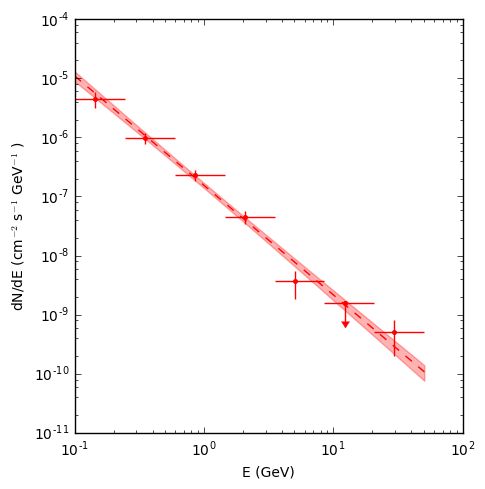

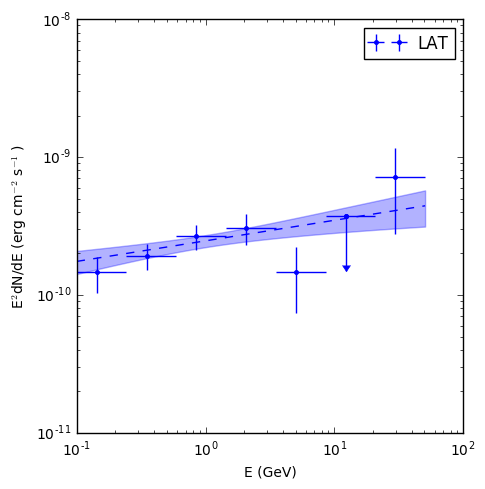

In [31]:
sed = fit_sed(pg_all)
ecent, GeVfluxPts, GeVfluxErrs, Eminus, Eplus, EsqFluxes, EsqFErrors, EGeV, FGeV, FGeVerr = getSED(sed,plot=True, plot_sed=True, 
                                                       save_spec="PG1553_LAT_all_spec.png", 
                                                       save_sed="PG1553_LAT_all_SED.png")


In [34]:
sed_data_all = (ecent, GeVfluxPts, GeVfluxErrs, Eminus, Eplus, EsqFluxes, EsqFErrors, EGeV, FGeV, FGeVerr)
dump_pickle(sed_data_all, 'pg1553_lat_sed_all.pkl')


# Fitting SED

In [39]:
fPL = lambda E,N0,E0,gamma: N0*(E/E0)**(-1*gamma)
ferrPL = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

fLP = lambda E,N0,alpha,beta,Eb: N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))
ferrLP = lambda E,F,N0,N0err,alpha,dalpha,beta,dbeta,Eb: \
        F*np.sqrt(N0err**2/N0**2 + (np.log(E/Eb))**2 * dalpha**2 + \
                  (np.log(E/Eb))**2 * (np.log10(E/Eb))**2 * dbeta**2)



In [40]:
def e_log_para(E, N0, Ind, Ep):
    #Ind is negative
    #return N0*(np.array(E)/1.)**(Ind)
    return N0*10.0**(Ind*(np.log10(np.array(E)/Ep))**2)/np.array(E)**2

def log_para(E, N0, alpha, beta, Eb):
    return N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))

def log_log_para(E, N0, alpha, beta, Eb):
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)


def PL_1TeV(E, N0, Ind):
    return N0*(np.array(E)/1.)**(Ind)

def PLexpcut_1TeV(E, N0, Ind, Ecut):
    slice_ind1 = np.where(E<Ecutt)
    slice_ind2 = np.where(E>=Ecutt)
    dnde = np.zeros_like(E).astype('float')
    dnde[slice_ind1] = N0*(np.array(E[slice_ind1])/1.)**(Ind)
    dnde[slice_ind2] = N0*(np.array(E[slice_ind2])/1.)**(Ind)
    return N0*(np.array(E)/1.)**(Ind)

def log_PL_1TeV(E, N0, Ind):
    return  np.log10(N0)+(Ind)*np.log10(np.array(E)/1.)


def PL_400GeV(E, N0, Ind):
    return N0*(np.array(E)/0.4)**(Ind)
def log_lin(E, N0, Ind):
    return np.log10(N0)+Ind*np.log10(np.array(E))

def PL(E, N0, Ind, Enorm=1.0):
    return N0*(np.array(E)/Enorm)**(Ind)





def chisq(y_vals, y_expected, y_errs, num_params=1):
    #returns chi2, dof, red_chi2
    #  for reduced chisq test, under the assumption of Poisson counting
    #  we have lnL = const - (1/2.)*chi2
    if y_vals.shape[0] != y_expected.shape[0]:
        print("Inconsistent input sizes")
        return
    #z = (y_vals[i] - y_expected[i]) / y_errs[i]    
    z = (y_vals - y_expected) / y_errs
    chi2 = np.sum(z ** 2)
    chi2dof = chi2 / (y_vals.shape[0] - num_params)
    return chi2, (y_vals.shape[0] - num_params), chi2dof




# Fitting in log space, large covariance for log parabola model

rel [ 0.04036939  0.03630769  0.05270758  0.08291367  0.2122905   0.51821862]
abs log apprx [ 0.01754174  0.01577516  0.02291184  0.03609181  0.09362031  0.24924215]
Power-law fit param 0 = 8.932e-08 +/- 4.359e-08
Power-law fit param 1 = -3.4 +/- 0.4269
Log-parabola fit param 0 = 1.751e-05 +/- 30.11
Log-parabola fit param 1 = 2.563 +/- 1.058e+06
Log-parabola fit param 2 = 1.816 +/- 0.3971
Log-parabola fit param 3 = 0.2201 +/- 1.476e+05
Power-law mode Chisq is 126.031499544, dof is 3, reduced Chisq is 42.010499848
Log-parabola model Chisq is 4.83528008644, dof is 2, reduced Chisq is 2.41764004322


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


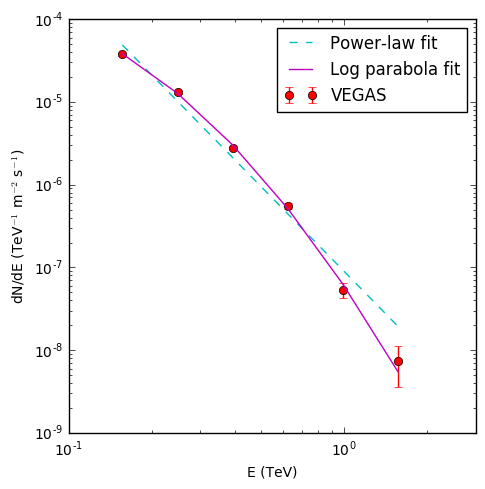

In [317]:
#method='trf', ftol=1e-10, loss='soft_l1')
### soft L1

print("rel {0}".format(df_spec.df.values/df_spec.f.values))
print("abs log apprx {0}".format((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.))
paramsPLlog, covariacesPLlog = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(df_spec.f.values), p0=[1.5e-10, -3.2],
                                       sigma=(np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2., absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog, covariacesLogParalog = curve_fit(log_log_para, (df_spec.E.values),
                                        np.log10(df_spec.f.values), p0=[1.5e-9, 2.2, 1.4, 0.8],
                                        sigma=(np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2., absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)

for i in [0,1]:
    print("Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))

for i in [0,1, 2, 3]:
    print("Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog[i], np.sqrt(abs(covariacesLogParalog[i,i]))))


#ddof is the number of parameters
#chisqPL, dofPL, redchisqPL = chisq((df_spec.f.values), PL_1TeV(df_spec.E, *paramsPLlog), (df_spec.df.values), num_params=3)
#chisqLP, dofLP, redchisqLP = chisq((df_spec.f.values), log_para(df_spec.E, *paramsLogParalog), (df_spec.df.values), num_params=4)
chisqPL, dofPL, redchisqPL = chisq(np.log10(df_spec.f.values), log_PL_1TeV(df_spec.E, *paramsPLlog),
                                   ((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.), num_params=3)
chisqLP, dofLP, redchisqLP = chisq(np.log10(df_spec.f.values), log_log_para(df_spec.E, *paramsLogParalog),
                                   ((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.), num_params=4)


print("Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL, dofPL, redchisqPL))
print("Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP, dofLP, redchisqLP))


fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (TeV)')

ax.set_ylabel('dN/dE (TeV$^{-1}$ m$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
ax.errorbar(df_spec.E, df_spec.f, yerr=df_spec.df, color='r', fmt='o', label="VEGAS")

#ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPL), 'g-', label="Power-law fit linear")
#ax.plot(df_spec.E, log_para(df_spec.E, *paramsLogPara), 'k-', label="Log parabola fit linear")

ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog), 'c--', label="Power-law fit")
#ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog_noErrorBar), 'b--', label="Power-law fit w/o flux error")
ax.plot(df_spec.E, log_para(df_spec.E, *paramsLogParalog), 'm-', label="Log parabola fit")



ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
ax.set_xlim(0.100,3.000)
ax.legend(loc='best')
plt.tight_layout()
#fig.savefig('RXJ0648_spec_2010vsUA.eps',format='eps', dpi=1000)

plt.show()




# Fix Eb

Fixing Eb at 0.2
Power-law fit param 0 = 1.073e-07 +/- 1.729e-08
Power-law fit param 1 = -3.4 +/- 0.1495
Log-parabola fit param 0 = 2.222e-05 +/- 7.299e-07
Log-parabola fit param 1 = 2.414 +/- 0.1195
Log-parabola fit param 2 = 1.806 +/- 0.2688
Power-law mode Chisq is 136.901422005, dof is 4, reduced Chisq is 34.2253555012
Log-parabola model Chisq is 4.83315809418, dof is 3, reduced Chisq is 1.61105269806


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


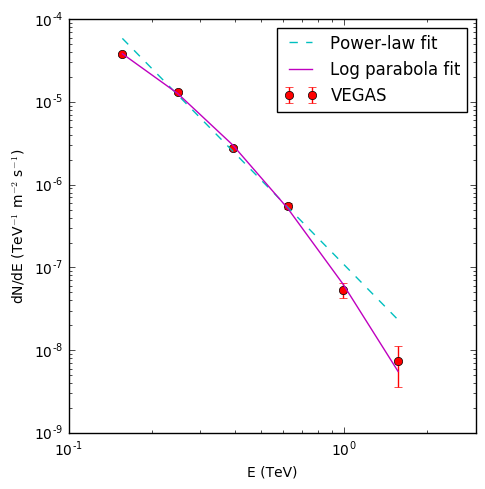

In [62]:
#method='trf', ftol=1e-10, loss='soft_l1')
### soft L1

Eb_fixed = 0.2
def log_log_para_fixEb(E, N0, alpha, beta):
    Eb=Eb_fixed
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)

print("Fixing Eb at {}".format(Eb_fixed))
paramsPLlog, covariacesPLlog = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(df_spec.f.values), p0=[1.5e-10, -3.2],
                                       sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog, covariacesLogParalog = curve_fit(log_log_para_fixEb, (df_spec.E.values),
                                        np.log10(df_spec.f.values), p0=[1.5e-9, 2.2, 1.4],
                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)

for i in [0,1]:
    print("Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))

lp_fix_params = []
dlp_fix_params = []


for i in [0,1, 2]:
    lp_fix_params.append(paramsLogParalog[i])
    dlp_fix_params.append(np.sqrt(abs(covariacesLogParalog[i,i])))
    print("Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog[i], np.sqrt(abs(covariacesLogParalog[i,i]))))



#ddof is the number of parameters
#chisqPL, dofPL, redchisqPL = chisq((df_spec.f.values), PL_1TeV(df_spec.E, *paramsPLlog), (df_spec.df.values), num_params=3)
#chisqLP, dofLP, redchisqLP = chisq((df_spec.f.values), log_para(df_spec.E, *paramsLogParalog), (df_spec.df.values), num_params=4)
chisqPL, dofPL, redchisqPL = chisq(np.log10(df_spec.f.values), log_PL_1TeV(df_spec.E, *paramsPLlog),
                                   ((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.),
                                   num_params=2)
chisqLP, dofLP, redchisqLP = chisq(np.log10(df_spec.f.values), log_log_para_fixEb(df_spec.E, *paramsLogParalog),
                                   ((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.),
                                   num_params=3)


print("Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL, dofPL, redchisqPL))
print("Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP, dofLP, redchisqLP))


fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (TeV)')

ax.set_ylabel('dN/dE (TeV$^{-1}$ m$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
ax.errorbar(df_spec.E, df_spec.f, yerr=df_spec.df, color='r', fmt='o', label="VEGAS")

#ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPL), 'g-', label="Power-law fit linear")
#ax.plot(df_spec.E, log_para(df_spec.E, *paramsLogPara), 'k-', label="Log parabola fit linear")

ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog), 'c--', label="Power-law fit")
#ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog_noErrorBar), 'b--', label="Power-law fit w/o flux error")
ax.plot(df_spec.E, 10**log_log_para_fixEb(df_spec.E, *paramsLogParalog), 'm-', label="Log parabola fit")



ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
ax.set_xlim(0.100,3.000)
ax.legend(loc='best')
plt.tight_layout()
#fig.savefig('RXJ0648_spec_2010vsUA.eps',format='eps', dpi=1000)

plt.show()





# Deabsorb

In [67]:
#method='trf', ftol=1e-10, loss='soft_l1')
### soft L1
from VHEObserverTools.VOT import *
from VHEObserverTools.VOTPlot import Plot, PlotSpectrum
from VHEObserverTools.VOTSpectrum import *


eMin = 0.1
eMax = 10000
Nbins = 10000
eblModel = "Dominguez"
redshift = 0.069
#spectralModel="PowerLaw"
spectralModel="LogParabola"
#PowerLaw: a simple power law with normalization ('N0', cm^-2 s^-1 GeV^-1),
#          index ('index', negative), pivot energy ("E0", GeV).
#Log-parabola fit param 0 = 2.222e-05 +/- 7.299e-07
#Log-parabola fit param 1 = 2.414 +/- 0.1195
#Log-parabola fit param 2 = 1.806 +/- 0.2688
spectralParsLogPara = {"N0":2.222e-05,"alpha":-2.414, "beta":-1.806, "E0":0.2}

#VS_BLLac = VOTSpectrum([],[],eMin, 300, Nbins, eblModel, redshift, spectralModel,**spectralPars3FGL)
VS_BLLac = VOTSpectrum(df_spec.E, df_spec.f, eblModel="Dominguez", redshift=redshift)

taus = VS_BLLac.interpolated_taus[0:,0]
dNdE_deabsorbed = df_spec.f*np.exp(taus)

Eb_fixed = 0.2
def log_log_para_fixEb(E, N0, alpha, beta):
    Eb=Eb_fixed
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)

print("Fixing Eb at {}".format(Eb_fixed))
paramsPLlog, covariacesPLlog = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(df_spec.f.values), p0=[1.5e-10, -3.2],
                                       sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog, covariacesLogParalog = curve_fit(log_log_para_fixEb, (df_spec.E.values),
                                        np.log10(df_spec.f.values), p0=[1.5e-9, 2.2, 1.4],
                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)

for i in [0,1]:
    print("Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))

lp_fix_params = []
dlp_fix_params = []


for i in [0,1, 2]:
    lp_fix_params.append(paramsLogParalog[i])
    dlp_fix_params.append(np.sqrt(abs(covariacesLogParalog[i,i])))
    print("Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog[i], np.sqrt(abs(covariacesLogParalog[i,i]))))



#ddof is the number of parameters
#chisqPL, dofPL, redchisqPL = chisq((df_spec.f.values), PL_1TeV(df_spec.E, *paramsPLlog), (df_spec.df.values), num_params=3)
#chisqLP, dofLP, redchisqLP = chisq((df_spec.f.values), log_para(df_spec.E, *paramsLogParalog), (df_spec.df.values), num_params=4)
chisqPL, dofPL, redchisqPL = chisq(np.log10(df_spec.f.values), log_PL_1TeV(df_spec.E, *paramsPLlog),
                                   ((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.),
                                   num_params=2)
chisqLP, dofLP, redchisqLP = chisq(np.log10(df_spec.f.values), log_log_para_fixEb(df_spec.E, *paramsLogParalog),
                                   ((np.log10(df_spec.f.values+df_spec.df.values)-np.log10(df_spec.f.values-df_spec.df.values))/2.),
                                   num_params=3)


print("Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL, dofPL, redchisqPL))
print("Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP, dofLP, redchisqLP))


fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (TeV)')

ax.set_ylabel('dN/dE (TeV$^{-1}$ m$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
ax.errorbar(df_spec.E, df_spec.f, yerr=df_spec.df, color='r', fmt='o', label="VEGAS")

ax.errorbar(df_spec.E, dNdE_deabsorbed, yerr=df_spec.df**np.exp(taus), color='b', fmt='o', label="VEGAS deabsorbed")


#ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPL), 'g-', label="Power-law fit linear")
#ax.plot(df_spec.E, log_para(df_spec.E, *paramsLogPara), 'k-', label="Log parabola fit linear")

ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog), 'c--', label="Power-law fit")
#ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog_noErrorBar), 'b--', label="Power-law fit w/o flux error")
ax.plot(df_spec.E, 10**log_log_para_fixEb(df_spec.E, *paramsLogParalog), 'm-', label="Log parabola fit")



ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
ax.set_xlim(0.100,3.000)
ax.legend(loc='best')
plt.tight_layout()
#fig.savefig('RXJ0648_spec_2010vsUA.eps',format='eps', dpi=1000)

plt.show()






ImportError: No module named VHEObserverTools.VOT

In [102]:
df_finke0_07=pd.read_csv("tau_modelC_total/tau_modelC_total_z0.07.dat", header=None, sep=r'\s+', names=['TeV', 'tau'])
taus_finke = []
for e_ in df_spec.E:
    print(e_)
    if e_ > 0.5:
        slice_ = np.where(abs(df_finke0_07['TeV'].values-e_)<1.8e-2)
    else:
        slice_ = np.where(abs(df_finke0_07['TeV'].values-e_)<1.5e-2)
    print(df_finke0_07['TeV'].values[slice_])
    print(df_finke0_07['tau'].values[slice_])
    taus_finke.append(df_finke0_07['tau'].values[slice_][0])

print(taus_finke)

0.1567
[ 0.1584893]
[ 0.04481025]
0.2484
[ 0.2511886]
[ 0.1223728]
0.3937
[ 0.3981072]
[ 0.2770361]
0.6239
[ 0.6309573]
[ 0.5042918]
0.9888
[ 1.]
[ 0.7519897]
1.567
[ 1.584893]
[ 0.9677932]
[0.044810250000000003, 0.1223728, 0.27703610000000001, 0.50429179999999996, 0.75198969999999998, 0.96779319999999991]


Fixing Eb at 0.2
Power-law fit param 0 = 1.073e-07 +/- 1.729e-08
Power-law fit param 1 = -3.4 +/- 0.1495
Log-parabola fit param 0 = 2.222e-05 +/- 7.299e-07
Log-parabola fit param 1 = 2.414 +/- 0.1195
Log-parabola fit param 2 = 1.806 +/- 0.2688
Deabsorbed Power-law fit param 0 = 1.237e-07 +/- 3.298e-08
Deabsorbed Power-law fit param 1 = -3.4 +/- 0.1837
Deabsorbed Log-parabola fit param 0 = 2.363e-05 +/- 7.473e-07
Deabsorbed Log-parabola fit param 1 = 2.265 +/- 0.1168
Deabsorbed Log-parabola fit param 2 = 1.448 +/- 0.2573
Power-law mode Chisq is 138.484021063, dof is 4, reduced Chisq is 34.6210052657

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10



Log-parabola model Chisq is 4.92410519497, dof is 3, reduced Chisq is 1.64136839832
Deabsorbed Power-law mode Chisq is 209.769708015, dof is 4, reduced Chisq is 52.4424270038
Deabsorbed Log-parabola model Chisq is 5.04707754054, dof is 3, reduced Chisq is 1.68235918018


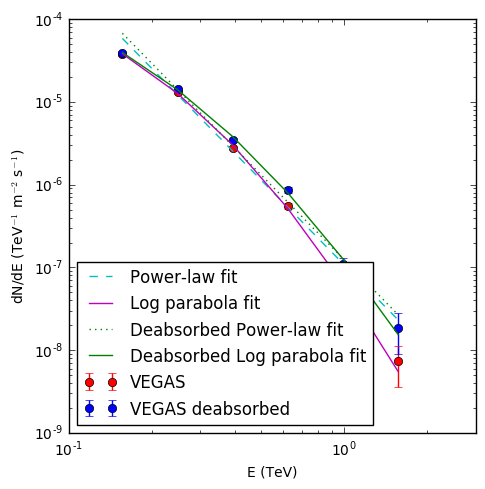

In [81]:
taus = [ 0.03566653,0.09816917,0.23274883,0.44965831,0.70432338,0.91634126]
dNdE_deabsorbed = df_spec.f*np.exp(taus)


Eb_fixed = 0.2
def log_log_para_fixEb(E, N0, alpha, beta):
    Eb=Eb_fixed
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)

print("Fixing Eb at {}".format(Eb_fixed))
paramsPLlog, covariacesPLlog = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(df_spec.f.values), p0=[1.5e-10, -3.2],
                                       sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog, covariacesLogParalog = curve_fit(log_log_para_fixEb, (df_spec.E.values),
                                        np.log10(df_spec.f.values), p0=[1.5e-9, 2.2, 1.4],
                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)


paramsPLlog_deabs, covariacesPLlog_deabs = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(dNdE_deabsorbed), p0=[1.5e-10, -3.2],
                                       sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog_deabs, covariacesLogParalog_deabs = curve_fit(log_log_para_fixEb, (df_spec.E.values),
                                        np.log10(dNdE_deabsorbed), p0=[1.5e-9, 2.2, 1.4],
                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)

# First pass to get Eb: 
#paramsLogParalog_deabs, covariacesLogParalog_deabs = curve_fit(log_log_para, (df_spec.E.values),
#                                        np.log10(dNdE_deabsorbed), p0=[1.5e-9, 2.2, 1.4, 0.2],
#                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
#                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)



for i in [0,1]:
    print("Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))

lp_fix_params = []
dlp_fix_params = []


for i in [0,1, 2]:
    lp_fix_params.append(paramsLogParalog[i])
    dlp_fix_params.append(np.sqrt(abs(covariacesLogParalog[i,i])))
    print("Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog[i], np.sqrt(abs(covariacesLogParalog[i,i]))))


for i in [0,1]:
    print("Deabsorbed Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog_deabs[i], np.sqrt(abs(covariacesPLlog_deabs[i,i]))))

lp_fix_params_deabs = []
dlp_fix_params_deabs = []


for i in [0,1, 2]:
#for i in [0,1, 2, 3]:
    lp_fix_params_deabs.append(paramsLogParalog_deabs[i])
    dlp_fix_params_deabs.append(np.sqrt(abs(covariacesLogParalog_deabs[i,i])))
    print("Deabsorbed Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog_deabs[i], np.sqrt(abs(covariacesLogParalog_deabs[i,i]))))



#ddof is the number of parameters
#chisqPL, dofPL, redchisqPL = chisq((df_spec.f.values), PL_1TeV(df_spec.E, *paramsPLlog), (df_spec.df.values), num_params=3)
#chisqLP, dofLP, redchisqLP = chisq((df_spec.f.values), log_para(df_spec.E, *paramsLogParalog), (df_spec.df.values), num_params=4)
chisqPL, dofPL, redchisqPL = chisq(np.log10(df_spec.f.values), log_PL_1TeV(df_spec.E, *paramsPLlog),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=2)
chisqLP, dofLP, redchisqLP = chisq(np.log10(df_spec.f.values), log_log_para_fixEb(df_spec.E, *paramsLogParalog),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=3)


print("Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL, dofPL, redchisqPL))
print("Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP, dofLP, redchisqLP))

chisqPL_deabs, dofPL_deabs, redchisqPL_deabs = chisq(np.log10(dNdE_deabsorbed), log_PL_1TeV(df_spec.E, *paramsPLlog_deabs),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=2)
chisqLP_deabs, dofLP_deabs, redchisqLP_deabs = chisq(np.log10(dNdE_deabsorbed), log_log_para_fixEb(df_spec.E, *paramsLogParalog_deabs),
#chisqLP_deabs, dofLP_deabs, redchisqLP_deabs = chisq(np.log10(dNdE_deabsorbed), log_log_para(df_spec.E, *paramsLogParalog_deabs),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=3)


print("Deabsorbed Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL_deabs, dofPL_deabs, redchisqPL_deabs))
print("Deabsorbed Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP_deabs, dofLP_deabs, redchisqLP_deabs))



fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (TeV)')

ax.set_ylabel('dN/dE (TeV$^{-1}$ m$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
ax.errorbar(df_spec.E, df_spec.f, yerr=df_spec.df, color='r', fmt='o', label="VEGAS")

ax.errorbar(df_spec.E, dNdE_deabsorbed, yerr=df_spec.df*np.exp(taus), color='b', fmt='o', label="VEGAS deabsorbed")


ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog), 'c--', label="Power-law fit")
ax.plot(df_spec.E, 10**log_log_para_fixEb(df_spec.E, *paramsLogParalog), 'm-', label="Log parabola fit")

ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog_deabs), 'g:', label="Deabsorbed Power-law fit")
ax.plot(df_spec.E, 10**log_log_para_fixEb(df_spec.E, *paramsLogParalog_deabs), 'g-', label="Deabsorbed Log parabola fit")
#ax.plot(df_spec.E, 10**log_log_para(df_spec.E, *paramsLogParalog_deabs), 'g-', label="Deabsorbed Log parabola fit")




ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
ax.set_xlim(0.100,3.000)
ax.legend(loc='best')
plt.tight_layout()
#fig.savefig('RXJ0648_spec_2010vsUA.eps',format='eps', dpi=1000)

plt.show()





# Finke deabsorbed

Fixing Eb at 0.2
Power-law fit param 0 = 1.073e-07 +/- 1.729e-08
Power-law fit param 1 = -3.4 +/- 0.1495
Log-parabola fit param 0 = 2.222e-05 +/- 7.299e-07
Log-parabola fit param 1 = 2.414 +/- 0.1195
Log-parabola fit param 2 = 1.806 +/- 0.2688
Deabsorbed Power-law fit param 0 = 1.237e-07 +/- 3.298e-08
Deabsorbed Power-law fit param 1 = -3.4 +/- 0.1837
Deabsorbed Log-parabola fit param 0 = 2.363e-05 +/- 7.473e-07
Deabsorbed Log-parabola fit param 1 = 2.265 +/- 0.1168
Deabsorbed Log-parabola fit param 2 = 1.448 +/- 0.2573
Power-law mode Chisq is 138.484021063, dof is 4, reduced Chisq is 34.6210052657


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


Log-parabola model Chisq is 4.92410519497, dof is 3, reduced Chisq is 1.64136839832
Deabsorbed Power-law mode Chisq is 209.769708015, dof is 4, reduced Chisq is 52.4424270038
Deabsorbed Log-parabola model Chisq is 5.04707754054, dof is 3, reduced Chisq is 1.68235918018


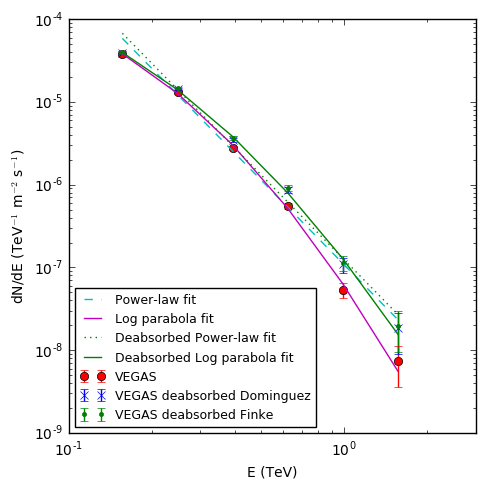

In [108]:
taus = [ 0.03566653,0.09816917,0.23274883,0.44965831,0.70432338,0.91634126]
dNdE_deabsorbed = df_spec.f*np.exp(taus)
dNdE_deabsorbed_finke = df_spec.f*np.exp(taus_finke)



Eb_fixed = 0.2
def log_log_para_fixEb(E, N0, alpha, beta):
    Eb=Eb_fixed
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)

print("Fixing Eb at {}".format(Eb_fixed))
paramsPLlog, covariacesPLlog = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(df_spec.f.values), p0=[1.5e-10, -3.2],
                                       sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog, covariacesLogParalog = curve_fit(log_log_para_fixEb, (df_spec.E.values),
                                        np.log10(df_spec.f.values), p0=[1.5e-9, 2.2, 1.4],
                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)


paramsPLlog_deabs, covariacesPLlog_deabs = curve_fit(log_PL_1TeV, (df_spec.E.values),
                                       np.log10(dNdE_deabsorbed), p0=[1.5e-10, -3.2],
                                       sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True,
                                       method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                       #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                       #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)
paramsLogParalog_deabs, covariacesLogParalog_deabs = curve_fit(log_log_para_fixEb, (df_spec.E.values),
                                        np.log10(dNdE_deabsorbed), p0=[1.5e-9, 2.2, 1.4],
                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)

# First pass to get Eb: 
#paramsLogParalog_deabs, covariacesLogParalog_deabs = curve_fit(log_log_para, (df_spec.E.values),
#                                        np.log10(dNdE_deabsorbed), p0=[1.5e-9, 2.2, 1.4, 0.2],
#                                        sigma=(0.434*(df_spec.df/df_spec.f)), absolute_sigma=True, #) #approx abs
#                                        method='trf', ftol=1e-10, loss='soft_l1')#approx abs
                                        #sigma=(df_spec.df.values/df_spec.f.values), absolute_sigma=False) #rel
                                        #wrong: sigma=np.log10(df_spec.df.values), absolute_sigma=True)



for i in [0,1]:
    print("Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))

lp_fix_params = []
dlp_fix_params = []


for i in [0,1, 2]:
    lp_fix_params.append(paramsLogParalog[i])
    dlp_fix_params.append(np.sqrt(abs(covariacesLogParalog[i,i])))
    print("Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog[i], np.sqrt(abs(covariacesLogParalog[i,i]))))


for i in [0,1]:
    print("Deabsorbed Power-law fit param %d = %.4g +/- %.4g" % (i, paramsPLlog_deabs[i], np.sqrt(abs(covariacesPLlog_deabs[i,i]))))

lp_fix_params_deabs = []
dlp_fix_params_deabs = []


for i in [0,1, 2]:
#for i in [0,1, 2, 3]:
    lp_fix_params_deabs.append(paramsLogParalog_deabs[i])
    dlp_fix_params_deabs.append(np.sqrt(abs(covariacesLogParalog_deabs[i,i])))
    print("Deabsorbed Log-parabola fit param %d = %.4g +/- %.4g" % (i, paramsLogParalog_deabs[i], np.sqrt(abs(covariacesLogParalog_deabs[i,i]))))



#ddof is the number of parameters
#chisqPL, dofPL, redchisqPL = chisq((df_spec.f.values), PL_1TeV(df_spec.E, *paramsPLlog), (df_spec.df.values), num_params=3)
#chisqLP, dofLP, redchisqLP = chisq((df_spec.f.values), log_para(df_spec.E, *paramsLogParalog), (df_spec.df.values), num_params=4)
chisqPL, dofPL, redchisqPL = chisq(np.log10(df_spec.f.values), log_PL_1TeV(df_spec.E, *paramsPLlog),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=2)
chisqLP, dofLP, redchisqLP = chisq(np.log10(df_spec.f.values), log_log_para_fixEb(df_spec.E, *paramsLogParalog),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=3)


print("Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL, dofPL, redchisqPL))
print("Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP, dofLP, redchisqLP))

chisqPL_deabs, dofPL_deabs, redchisqPL_deabs = chisq(np.log10(dNdE_deabsorbed), log_PL_1TeV(df_spec.E, *paramsPLlog_deabs),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=2)
chisqLP_deabs, dofLP_deabs, redchisqLP_deabs = chisq(np.log10(dNdE_deabsorbed), log_log_para_fixEb(df_spec.E, *paramsLogParalog_deabs),
#chisqLP_deabs, dofLP_deabs, redchisqLP_deabs = chisq(np.log10(dNdE_deabsorbed), log_log_para(df_spec.E, *paramsLogParalog_deabs),
                                   0.434*(df_spec.df/df_spec.f),
                                   num_params=3)


print("Deabsorbed Power-law mode Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqPL_deabs, dofPL_deabs, redchisqPL_deabs))
print("Deabsorbed Log-parabola model Chisq is {0}, dof is {1}, reduced Chisq is {2}".format(chisqLP_deabs, dofLP_deabs, redchisqLP_deabs))



fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (TeV)')

ax.set_ylabel('dN/dE (TeV$^{-1}$ m$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
ax.errorbar(df_spec.E, df_spec.f, yerr=df_spec.df, color='r', fmt='o', label="VEGAS")

ax.errorbar(df_spec.E, dNdE_deabsorbed, yerr=df_spec.df*np.exp(taus), color='b', fmt='x', label="VEGAS deabsorbed Dominguez")

ax.errorbar(df_spec.E, dNdE_deabsorbed_finke, yerr=df_spec.df*np.exp(taus_finke), 
            color='g', fmt='.', label="VEGAS deabsorbed Finke")


ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog), 'c--', label="Power-law fit")
ax.plot(df_spec.E, 10**log_log_para_fixEb(df_spec.E, *paramsLogParalog), 'm-', label="Log parabola fit")

ax.plot(df_spec.E, PL_1TeV(df_spec.E, *paramsPLlog_deabs), 'g:', label="Deabsorbed Power-law fit")
ax.plot(df_spec.E, 10**log_log_para_fixEb(df_spec.E, *paramsLogParalog_deabs), 'g-', label="Deabsorbed Log parabola fit")
#ax.plot(df_spec.E, 10**log_log_para(df_spec.E, *paramsLogParalog_deabs), 'g-', label="Deabsorbed Log parabola fit")




ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
ax.set_xlim(0.100,3.000)
ax.legend(loc='best', prop={'size':9})
plt.tight_layout()
#fig.savefig('RXJ0648_spec_2010vsUA.eps',format='eps', dpi=1000)

plt.show()






In [66]:
pwd

u'/Users/qifeng/Data/Blazars/BLLac/Fermi'

# Fitting in log space, still large covariance for log parabola model
# Fixing E_b works
# Plot in paper

Simul LAT gamma=1.829+/-0.211, 3-day LAT gamma=1.851+/-0.070


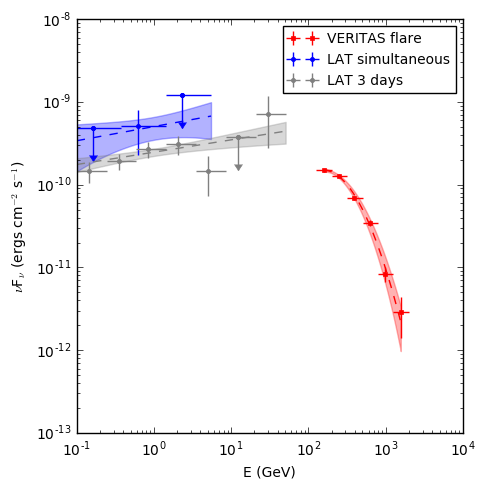

In [61]:
EsqFluxes = sqFluxes

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (GeV)')

ax.set_ylabel(r'$\nu$F$_\nu$ (ergs cm$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
#1e-7 is 1e-3 for flux conversion from TeV to GeV and 1e-4 from m^-2 to cm^-2
VEGeVminus = (df_spec.E*1e3)-(df_spec.lowE*1e3)
VEGeVplus = (df_spec.highE*1e3)-(df_spec.E*1e3)


ax.errorbar(df_spec.E*1e3, (df_spec.E*1e3)**2*df_spec.f*1e-7*gev2erg, xerr=[VEGeVminus, VEGeVplus], 
            yerr=(df_spec.E*1e3)**2*df_spec.df*1e-7*gev2erg, color='r', fmt='s', ms=3, mec="r",
            ecolor='r', capthick=0,label="VERITAS flare")

#ax.plot(df_spec.E*1e3, (df_spec.E*1e3)**2*PL_1TeV(df_spec.E, *paramsPLlog)*1e-7*gev2erg, 'c--', label="Power-law fit")
#ax.plot(df_spec.E*1e3, (df_spec.E*1e3)**2*log_para(df_spec.E, *paramsLogParalog)*1e-7*gev2erg, 'm-', label="Log parabola fit")


fLP = lambda E,N0,alpha,beta,Eb: N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))
ferrLP = lambda E,F,N0,N0err,alpha,dalpha,beta,dbeta,Eb: \
        F*np.sqrt(N0err**2/N0**2 + (np.log(E/Eb))**2 * dalpha**2 + \
                  (np.log(E/Eb))**2 * (np.log10(E/Eb))**2 * dbeta**2)

N0TeV=paramsLogParalog[0]
alphaTeV=paramsLogParalog[1]
betaTeV=paramsLogParalog[2]
#EbTeV = paramsLogParalog[3]
EbTeV = Eb_fixed
dN0TeV = np.sqrt(abs(covariacesLogParalog[0,0]))
dalphaTeV = np.sqrt(abs(covariacesLogParalog[1,1]))
dbetaTeV = np.sqrt(abs(covariacesLogParalog[2,2]))
#dEbTeVabs = np.sqrt(abs(covariacesLogParalog[3,3]))

VEGeV = np.logspace(np.log10(df_spec.E[0]*1e3),np.log10(df_spec.E.values[-1]*1e3),100)
#VFGeV = fLP(VEGeV,N0TeV*1.e-3,alphaTeV, betaTeV, 1000.)
#VFGeVerr = ferrLP(VEGeV,VFGeV,N0TeV*1.e-3,dN0TeV*1.e-3,alphaTeV,dalphaTeV,betaTeV,dbetaTeV, 1000.)

#ferrPL = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

#VFGeV = PL_1TeV(VEGeV, *paramsPLlog) 
#VFGeVerr = ferrPL(VEGeV,VFGeV,paramsPLlog[0]*1.e-3,abs(covariacesPLlog[0,0])*1.e-3,1000.,covariacesPLlog[1,1])
#VFGeV = PL_1TeV(VEGeV/1000., *paramsPLlog) 
#VFGeVerr = ferrPL(VEGeV/1000.,VFGeV,paramsPLlog[0],abs(covariacesPLlog[0,0]),1.,covariacesPLlog[1,1])

VFGeV = 10**log_log_para_fixEb(VEGeV/1000., *paramsLogParalog)
VFGeVerr = ferrLP(VEGeV,VFGeV,N0TeV*1e3,dN0TeV*1e3,alphaTeV,dalphaTeV,betaTeV,dbetaTeV, 200)


#print(VFGeV)
#print(VFGeVerr)
ax.plot(VEGeV,(VEGeV)**2*VFGeV*1e-7*gev2erg, color='r', ls='--')

ax.fill_between(VEGeV,(VEGeV)**2*(VFGeV-VFGeVerr)*1e-7*gev2erg,
                (VEGeV)**2*(VFGeV+VFGeVerr)*1e-7*gev2erg,alpha=0.3,color='r')




ax.errorbar(ecent_simul, EsqFluxes_simul, xerr=[Eminus_simul, Eplus_simul], yerr=EsqFErrors_simul,
            color='b', ecolor='b', capthick=0, fmt='.', label="LAT simultaneous")
ul_slice = np.where(np.array(EsqFErrors_simul)==0)
ax.errorbar(np.array(ecent_simul)[ul_slice], np.array(EsqFluxes_simul)[ul_slice], 
                    6.e-1*np.array(EsqFluxes_simul)[ul_slice], uplims=True, fmt='.', 
                    color='b',ecolor='b')


ax.plot(EGeV_simul,(EGeV_simul)**2*FGeV_simul*gev2erg, 'b--')
ax.fill_between(EGeV_simul,(EGeV_simul)**2*(FGeV_simul-FGeVerr_simul)*gev2erg,
                (EGeV_simul)**2*(FGeV_simul+FGeVerr_simul)*gev2erg,alpha=0.3,color='b')

ax.errorbar(ecent, EsqFluxes, xerr=[Eminus, Eplus], yerr=EsqFErrors,
            color='gray', ecolor='gray', capthick=0, fmt='.', label="LAT 3 days")
ul_slice_3d = np.where(np.array(EsqFErrors)==0)
ax.errorbar(np.array(ecent)[ul_slice_3d], np.array(EsqFluxes)[ul_slice_3d], 
                    6.e-1*np.array(EsqFluxes)[ul_slice_3d], uplims=True, fmt='.', 
                    color='gray',ecolor='gray')


ax.plot(EGeV,(EGeV)**2*FGeV*gev2erg, color='gray', ls='--')
ax.fill_between(EGeV,(EGeV)**2*(FGeV-FGeVerr)*gev2erg,
                (EGeV)**2*(FGeV+FGeVerr)*gev2erg,alpha=0.3,color='gray')


#ax.plot(EGeV,(EGeV)**2*FGeV*gev2erg, 'b--')
#ax.fill_between(EGeV,(EGeV)**2*(FGeV-FGeVerr)*gev2erg, (EGeV)**2*(FGeV+FGeVerr)*gev2erg,alpha=0.3,color='b')


ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
#ax.set_xlim(0.100,3.000)
ax.legend(loc='best', prop={'size':10})
plt.tight_layout()
fig.savefig('BLLac_gamma_SED_2016flare_logpara.pdf')
#fig.savefig('BLLac_gamma_SED_2016flare.png', dpi=300)

#plt.show()

print("Simul LAT gamma={:.3f}+/-{:.3f}, 3-day LAT gamma={:.3f}+/-{:.3f}".format(sed_simul.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').value(),
                                                                sed_simul.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').error(),
                                                                sed.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').value(),
                                                                sed.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').error()))

Simul LAT gamma=1.829+/-0.211, 3-day LAT gamma=1.851+/-0.070


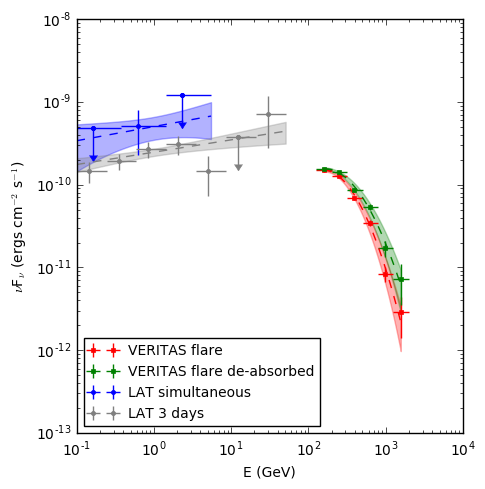

In [109]:
EsqFluxes = sqFluxes

fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)
ax.set_xlabel('E (GeV)')

ax.set_ylabel(r'$\nu$F$_\nu$ (ergs cm$^{-2}$ s$^{-1}$)')
#ax.set_ylim(1e-10, 1e-5)
#1e-7 is 1e-3 for flux conversion from TeV to GeV and 1e-4 from m^-2 to cm^-2
VEGeVminus = (df_spec.E*1e3)-(df_spec.lowE*1e3)
VEGeVplus = (df_spec.highE*1e3)-(df_spec.E*1e3)


ax.errorbar(df_spec.E*1e3, (df_spec.E*1e3)**2*df_spec.f*1e-7*gev2erg, xerr=[VEGeVminus, VEGeVplus], 
            yerr=(df_spec.E*1e3)**2*df_spec.df*1e-7*gev2erg, color='r', fmt='s', ms=3, mec="r",
            ecolor='r', capthick=0,label="VERITAS flare")

#ax.plot(df_spec.E*1e3, (df_spec.E*1e3)**2*PL_1TeV(df_spec.E, *paramsPLlog)*1e-7*gev2erg, 'c--', label="Power-law fit")
#ax.plot(df_spec.E*1e3, (df_spec.E*1e3)**2*log_para(df_spec.E, *paramsLogParalog)*1e-7*gev2erg, 'm-', label="Log parabola fit")


fLP = lambda E,N0,alpha,beta,Eb: N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))
ferrLP = lambda E,F,N0,N0err,alpha,dalpha,beta,dbeta,Eb: \
        F*np.sqrt(N0err**2/N0**2 + (np.log(E/Eb))**2 * dalpha**2 + \
                  (np.log(E/Eb))**2 * (np.log10(E/Eb))**2 * dbeta**2)

N0TeV=paramsLogParalog[0]
alphaTeV=paramsLogParalog[1]
betaTeV=paramsLogParalog[2]
#EbTeV = paramsLogParalog[3]
EbTeV = Eb_fixed
dN0TeV = np.sqrt(abs(covariacesLogParalog[0,0]))
dalphaTeV = np.sqrt(abs(covariacesLogParalog[1,1]))
dbetaTeV = np.sqrt(abs(covariacesLogParalog[2,2]))
#dEbTeVabs = np.sqrt(abs(covariacesLogParalog[3,3]))

VEGeV = np.logspace(np.log10(df_spec.E[0]*1e3),np.log10(df_spec.E.values[-1]*1e3),100)
#VFGeV = fLP(VEGeV,N0TeV*1.e-3,alphaTeV, betaTeV, 1000.)
#VFGeVerr = ferrLP(VEGeV,VFGeV,N0TeV*1.e-3,dN0TeV*1.e-3,alphaTeV,dalphaTeV,betaTeV,dbetaTeV, 1000.)

#ferrPL = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

#VFGeV = PL_1TeV(VEGeV, *paramsPLlog) 
#VFGeVerr = ferrPL(VEGeV,VFGeV,paramsPLlog[0]*1.e-3,abs(covariacesPLlog[0,0])*1.e-3,1000.,covariacesPLlog[1,1])
#VFGeV = PL_1TeV(VEGeV/1000., *paramsPLlog) 
#VFGeVerr = ferrPL(VEGeV/1000.,VFGeV,paramsPLlog[0],abs(covariacesPLlog[0,0]),1.,covariacesPLlog[1,1])

VFGeV = 10**log_log_para_fixEb(VEGeV/1000., *paramsLogParalog)
VFGeVerr = ferrLP(VEGeV,VFGeV,N0TeV*1e3,dN0TeV*1e3,alphaTeV,dalphaTeV,betaTeV,dbetaTeV, 200)


#print(VFGeV)
#print(VFGeVerr)
ax.plot(VEGeV,(VEGeV)**2*VFGeV*1e-7*gev2erg, color='r', ls='--')

ax.fill_between(VEGeV,(VEGeV)**2*(VFGeV-VFGeVerr)*1e-7*gev2erg,
                (VEGeV)**2*(VFGeV+VFGeVerr)*1e-7*gev2erg,alpha=0.3,color='r')



### Deabsorbed VERITAS 
ax.errorbar(df_spec.E*1e3, (df_spec.E*1e3)**2*dNdE_deabsorbed*1e-7*gev2erg, xerr=[VEGeVminus, VEGeVplus], 
            yerr=(df_spec.E*1e3)**2*df_spec.df*1e-7*gev2erg*np.exp(taus), color='g', fmt='s', ms=3, mec="g",
            ecolor='g', capthick=0,label="VERITAS flare de-absorbed")

N0TeV_deabs=paramsLogParalog_deabs[0]
alphaTeV_deabs=paramsLogParalog_deabs[1]
betaTeV_deabs=paramsLogParalog_deabs[2]
EbTeV = Eb_fixed
dN0TeV_deabs = np.sqrt(abs(covariacesLogParalog_deabs[0,0]))
dalphaTeV_deabs = np.sqrt(abs(covariacesLogParalog_deabs[1,1]))
dbetaTeV_deabs = np.sqrt(abs(covariacesLogParalog_deabs[2,2]))

VFGeV_deabs = 10**log_log_para_fixEb(VEGeV/1000., *paramsLogParalog_deabs)
VFGeVerr_deabs = ferrLP(VEGeV,VFGeV_deabs,N0TeV_deabs*1e3,dN0TeV_deabs*1e3,
                        alphaTeV_deabs,dalphaTeV_deabs,betaTeV_deabs,dbetaTeV_deabs, 200)


#print(VFGeV)
#print(VFGeVerr)
ax.plot(VEGeV,(VEGeV)**2*VFGeV_deabs*1e-7*gev2erg, color='g', ls='--')

ax.fill_between(VEGeV,(VEGeV)**2*(VFGeV_deabs-VFGeVerr_deabs)*1e-7*gev2erg,
                (VEGeV)**2*(VFGeV_deabs+VFGeVerr_deabs)*1e-7*gev2erg,alpha=0.3,color='g')




ax.errorbar(ecent_simul, EsqFluxes_simul, xerr=[Eminus_simul, Eplus_simul], yerr=EsqFErrors_simul,
            color='b', ecolor='b', capthick=0, fmt='.', label="LAT simultaneous")
ul_slice = np.where(np.array(EsqFErrors_simul)==0)
ax.errorbar(np.array(ecent_simul)[ul_slice], np.array(EsqFluxes_simul)[ul_slice], 
                    6.e-1*np.array(EsqFluxes_simul)[ul_slice], uplims=True, fmt='.', 
                    color='b',ecolor='b')


ax.plot(EGeV_simul,(EGeV_simul)**2*FGeV_simul*gev2erg, 'b--')
ax.fill_between(EGeV_simul,(EGeV_simul)**2*(FGeV_simul-FGeVerr_simul)*gev2erg,
                (EGeV_simul)**2*(FGeV_simul+FGeVerr_simul)*gev2erg,alpha=0.3,color='b')

ax.errorbar(ecent, EsqFluxes, xerr=[Eminus, Eplus], yerr=EsqFErrors,
            color='gray', ecolor='gray', capthick=0, fmt='.', label="LAT 3 days")
ul_slice_3d = np.where(np.array(EsqFErrors)==0)
ax.errorbar(np.array(ecent)[ul_slice_3d], np.array(EsqFluxes)[ul_slice_3d], 
                    6.e-1*np.array(EsqFluxes)[ul_slice_3d], uplims=True, fmt='.', 
                    color='gray',ecolor='gray')


ax.plot(EGeV,(EGeV)**2*FGeV*gev2erg, color='gray', ls='--')
ax.fill_between(EGeV,(EGeV)**2*(FGeV-FGeVerr)*gev2erg,
                (EGeV)**2*(FGeV+FGeVerr)*gev2erg,alpha=0.3,color='gray')


#ax.plot(EGeV,(EGeV)**2*FGeV*gev2erg, 'b--')
#ax.fill_between(EGeV,(EGeV)**2*(FGeV-FGeVerr)*gev2erg, (EGeV)**2*(FGeV+FGeVerr)*gev2erg,alpha=0.3,color='b')


ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(100,3000)
#ax.set_xlim(0.100,3.000)
ax.legend(loc='best', prop={'size':10})
plt.tight_layout()
#fig.savefig('BLLac_gamma_SED_2016flare_logpara_deabs.pdf')
fig.savefig('BLLac_gamma_SED_2016flare_logpara_deabs.png', dpi=300)

#fig.savefig('BLLac_gamma_SED_2016flare.png', dpi=300)

#plt.show()

print("Simul LAT gamma={:.3f}+/-{:.3f}, 3-day LAT gamma={:.3f}+/-{:.3f}".format(sed_simul.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').value(),
                                                                sed_simul.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').error(),
                                                                sed.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').value(),
                                                                sed.likeIn.ubAn.model[name].funcs['Spectrum'].getParam('Index').error()))

# Check if the fit converges with a relaxed criterion to delete weak sources 
## Changing TS lower from 3.0 to 1.0